# Convolutional Neural Network Demonstration

This notebook demonstrates a simple convolutional neural network model for handwritten digit classification.

## Import Required Libraries

Import the necessary libraries including PyTorch, torchvision, and matplotlib.

In [1]:
# Import the required libraries.
import torch
import torchvision

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torch import nn
from torch import optim
from torch.nn.functional import one_hot
from torchvision import transforms
from torchviz import make_dot
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

## Define CNN Architecture

Create a simple CNN class for the QMNIST dataset.

In [2]:
class SimpleCNN(nn.Module):
    """Define the CNN architecture for QMNIST dataset."""

    def __init__(self):
        """Initialize the CNN architecture."""
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32,
            kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64,
            kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128,
            kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)  # QMNIST has 10 classes.
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Set Hyperparameters and Data Preprocessing

Define hyperparameters and data transformation pipeline.

In [3]:
# Hyperparameters.
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 1 # Try increasing this value.

# Data preprocessing.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load Dataset and Initialize Model

Load the QMNIST dataset and initialize the CNN model with optimizer and loss function.

In [4]:
# Load QMNIST dataset and create a DataLoader.
train_dataset = torchvision.datasets.QMNIST(
    root="./data", what="train", download=True, transform=transform)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the network, loss function and optimizer.
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Visualize Model Architecture

Generate and save a visual representation of the model architecture.

In [5]:
# Create a dummy input tensor with the same shape as the input data.
dummy_input = torch.randn(1, 1, 28, 28)

# Generate the graph.
model_graph = make_dot(
    model(dummy_input), params=dict(model.named_parameters()))

# Save the graph to a file.
model_graph.format = "png"
model_graph.directory = "./lecture07/models"
model_graph.filename = "qmnist_model"

## Train the Model

Execute the training loop for the specified number of epochs.

In [6]:
# Training loop.
for epoch in range(NUM_EPOCHS):
    for images, labels in train_loader:

        # One-hot encode the labels.
        labels = one_hot(labels.long(), num_classes=10).float()

        # Forward pass.
        outputs = model(images)

        # Compute loss.
        loss = criterion(outputs, labels)

        # Backward pass and optimization.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")

print("Training complete.")

Epoch [1/1], Loss: 0.0057
Training complete.


## Export Model to ONNX

Save the trained model in ONNX format for deployment.

In [7]:
# Save the trained model in an ONNX file.
dummy_input = torch.randn(1, 1, 28, 28)
ONNX_FILE_PATH = "./models/qmnist_model.onnx"
torch.onnx.export(
    model, dummy_input, ONNX_FILE_PATH,
    input_names=["input"], output_names=["output"],
    dynamic_axes={
        "input": { 0: "batch_size" },
        "output": { 0: "batch_size" }
    }
)

print(f"Model saved to {ONNX_FILE_PATH}.")

Model saved to ./models/qmnist_model.onnx.


/var/folders/q3/2tkw4wl936l357n57y8sx0x80000gn/T/ipykernel_4348/389248586.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


## Evaluate Model Performance

Load test dataset and evaluate the model performance with various metrics.

In [8]:
# Load the test dataset.
test_dataset = torchvision.datasets.QMNIST(
    root="./data", what="test", download=True, transform=transform)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Evaluate the model on the test dataset.
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

# Compute metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9828
Precision: 0.9831
Recall: 0.9828
F1 Score: 0.9829


## Visualize Predictions

Display sample images with actual and predicted labels.

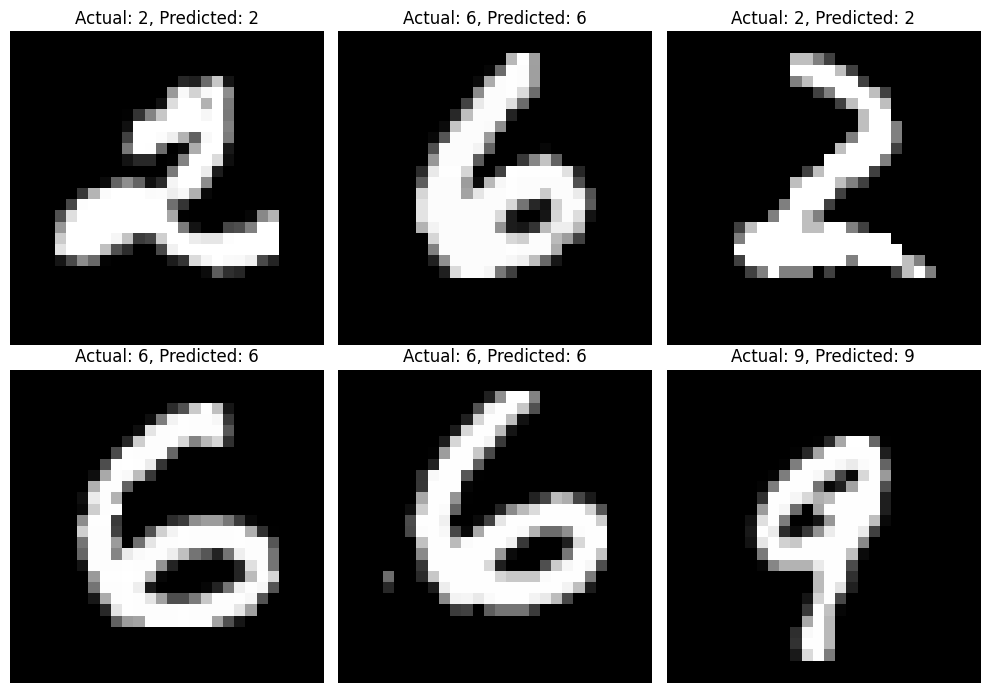

In [9]:
# Get predictions.
data_iter = iter(test_loader)
images, labels = next(data_iter)
labels = labels.float().unsqueeze(1)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the images with actual and predicted labels.
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()
for i in range(6):
    img = images[i].squeeze().numpy()
    ax = axes[i]
    ax.imshow(img, cmap="gray")
    ax.set_title(
        f"Actual: {int(labels[i].item())}, "
        f"Predicted: {int(predicted[i].item())}"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()